# Segmentation of e-shop customers

In this exercise we need to find segments with a simillar behavior. In order to do this we need to aggregate the information from  individual purchases.

Given data have the following columns:

* Customer ID 
* Date 
* Subtotal 
* Country

Aims of the exercise:

* create RFM dataframe
* perform KMeans clustering
* rescale data
* interprete clusters
* perform clustering with silhouette analysis
* perform the same analysis with modified  **RFM** model

Before we start let's have a little introduction into RFM model. Recency, frequency, monetary value is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures.

- **R**ecency means the number of days from the last purchase (the last number in dataset for individual customer).
- **F**requency tells about the number of purchases. Do not throw customers with a single purchase.
- **M**onetary shows amount spent over a given period of time

As first let's load the data and import the necessary modules.

In [58]:
# importing necessary modules
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

In [59]:
# data loading
df = pd.read_csv("eshop.csv")
df.head()

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


# Data Exploration

Let’s take a closer look at the data. The data have 222408 rows and 4 columns. There are 3 missing values in the Country column, so let's fill it with the most frequent country the Czech republic. The other method which could be implemented here is to check the ID of customer. If customer did more purchases and the value for country column was not missing, we can fill the missing value with a value which appeared previously. A trunsaction timeframe is taken from 1/1/2009 to 9/9/2015. 

In [60]:
print(df.info())
print('Datetime: from',df.Date.min(), ' to ', df.Date.max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22408 entries, 0 to 22407
Data columns (total 4 columns):
Customer ID    22408 non-null int64
Date           22408 non-null object
Subtotal       22408 non-null float64
Country        22405 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 700.4+ KB
None
Datetime: from 1/1/2009  to  9/9/2015


In [61]:
# filling misssing data
df.Country = df.Country.fillna('Czech Republic')

Are there any duplicates in the dataset? Let's check.

In [62]:
df.drop_duplicates()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22408 entries, 0 to 22407
Data columns (total 4 columns):
Customer ID    22408 non-null int64
Date           22408 non-null object
Subtotal       22408 non-null float64
Country        22408 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 700.4+ KB
None


As it is seen the number of enteries did not change so there are no duplicate values in the dataset. Let's now find out which countries buy the most from our eshop.

In [63]:
# Countries column
df = df.copy()
df_country = df.groupby('Country')['Customer ID'].count()
other = df_country[df_country<5].count()
list_counts = df_country[df_country>=5].to_list()
list_c_names = df_country[df_country>=5].keys().to_list()
list_counts.append(other)
list_c_names.append('Others')
country_df = pd.DataFrame({'Country':list_c_names, 'Count': list_counts})
display(country_df.sort_values(by='Count',  ascending=False))

,Country,Count
1,Czech Republic,21736
2,Slovakia,559
4,Others,38
0,Australia,29
3,United Kingdom,21


Customers from Czech republic and Slovakia buy the most from our eshop. Let's find out what was the maximum and minimum amount of the purchase.

In [64]:
# Subtotal column
df = df.copy()
df_subtotal = df.groupby('Customer ID')['Subtotal'].sum()
display(df_subtotal.sort_values(ascending=False))

Customer ID
4912     21392.38
6544     11427.92
9639      8945.18
13481     8739.21
12294     7851.53
           ...   
5442         2.05
2398         1.80
2867         1.68
8037         1.64
11428        1.18
Name: Subtotal, Length: 12829, dtype: float64

Let's find out which customer made the highest number of purchases.

In [65]:
# CustomerId column
df = df.copy()
df_count = df.groupby('Customer ID')['Subtotal'].count()
display(df_count.sort_values(ascending=False).head())

Customer ID
582     45
2482    32
2074    28
5291    28
4667    27
Name: Subtotal, dtype: int64

# Customer segmentation with RFM model

As a first step I will calculate the Recency, Frequency, Monetary values for each customer.

In [66]:
# setting the last day
df = df.copy()
df['Date'] = pd.to_datetime(df['Date'])
last_day = df['Date'].max() + datetime.timedelta(days=1)
#print(last_day)

# Grouping by CustomerID and aggregationg values
df_processed = df.groupby(['Customer ID']).agg({
        'Date': lambda x: (last_day - x.max()).days,
        'Customer ID': 'count',
        'Subtotal': 'sum'})

df_processed.rename(columns={'Date': 'Recency',
                         'Customer ID': 'Frequency',
                         'Subtotal': 'Monetary'}, inplace=True)
display(df_processed.head())

,Recency,Frequency,Monetary
Customer ID,,,
7,312,3,15.54
9,3051,1,13.20
30,3026,1,36.20
34,3104,1,86.00
38,3098,1,38.40


Now let's have look how our columns are distributed. As we can see the distributution of Frequency and Monetary columns have a similar shape and normalization is recommended for this type of distribution to follow a normal or near normal distribution. The Recency columns resembles right-skewed distribution. All of that would mean that our data should be standardized.

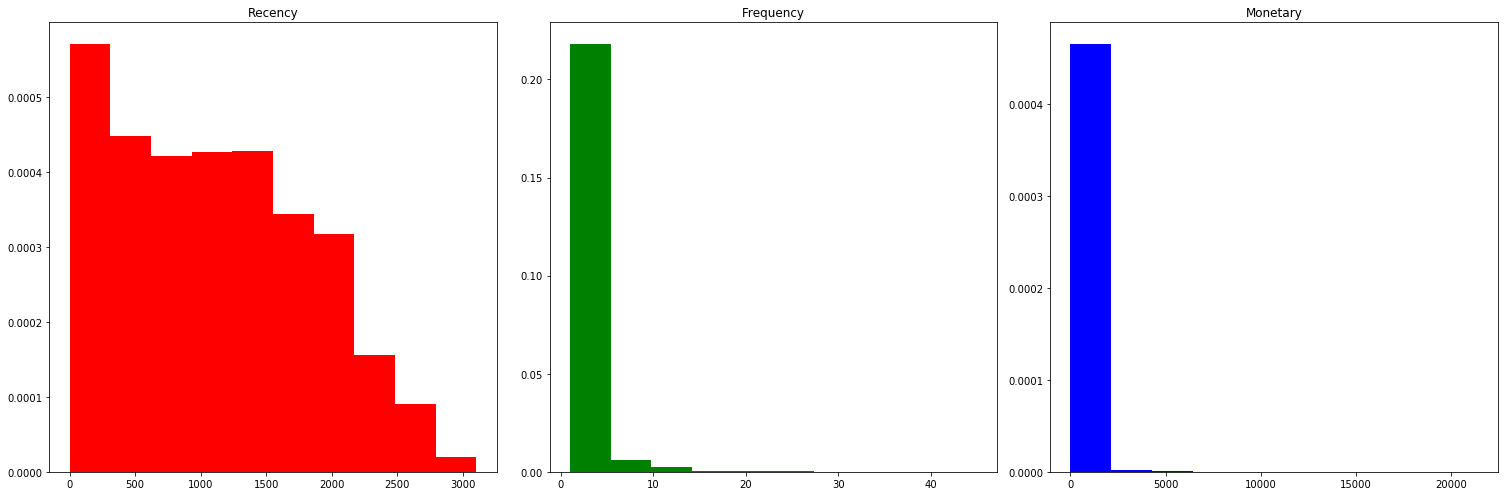

In [252]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))
ax0, ax1, ax2 = axes.flatten()
ax0.hist(df_processed.Recency, density=True, histtype='bar', color='red')
ax0.set_title('Recency')
ax1.hist(df_processed.Frequency, density=True, histtype='bar', color='green')
ax1.set_title('Frequency')
ax2.hist(df_processed.Monetary, density=True, histtype='bar', color='blue')
ax2.set_title('Monetary')
fig.tight_layout()

_Figure 1: The distribution of Recency, Frequency and Monetary columns. The Figure shows that data require standardization before using KMeans._

# Data standardization

As was previously seen the data require standardization. Let's first normalize and standardize our data.

The data can be normalized by different methods:

* log transformation with numpy log function
* box–cox transformation in scipy.stats module
* square root transformation
* normalization using scikit-learn Normalizer used for 2D 3D dimentional data

In [253]:
df_processed_for_transformation = df_processed.copy()
df_processed_for_transformation.head()

,Recency,Frequency,Monetary
Customer ID,,,
7,312,3,15.54
9,3051,1,13.20
30,3026,1,36.20
34,3104,1,86.00
38,3098,1,38.40


For Monetary column I decided to use box-cox transformation as I observed a nicely shaped distribution after transformation (log transfomation did not result in this nice distribution).

Text(0.5, 1.0, 'Normalized Monetary Data')

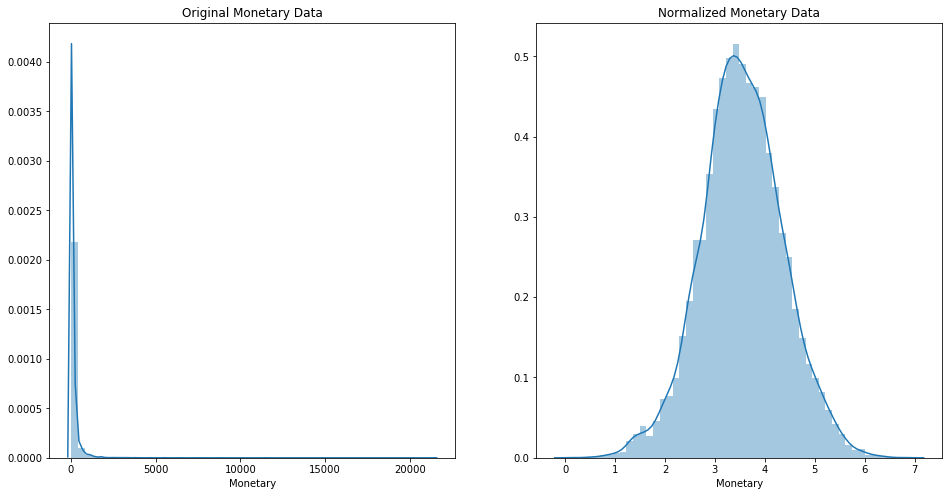

In [254]:
# normalize Monetary column with box-cox
normalized_data = stats.boxcox(df_processed_for_transformation.Monetary)

# plot both together to compare
fig, ax=plt.subplots(1,2, figsize=(16,8))
sns.distplot(df_processed_for_transformation.Monetary, ax=ax[0])
ax[0].set_title("Original Monetary Data")
sns.distplot(normalized_data[0], ax=ax[1])
plt.xlabel("Monetary")
ax[1].set_title("Normalized Monetary Data")

_Figure 2: The distribution of Monetary column before and after normalization with box-cox transformation._

I tried diiferent methods to normalize Frequency column at the end I used box-cox method for normalization even though it resulted in binomial distribution.

Text(0.5, 1.0, 'Normalized Frequency Data')

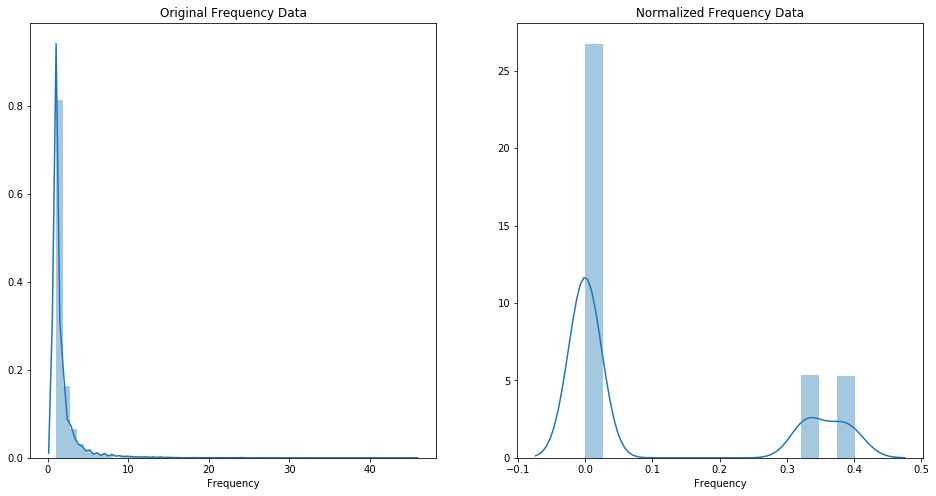

In [255]:
normalized_data1 = stats.boxcox(df_processed_for_transformation.Frequency)
# plot both together to compare
fig, ax=plt.subplots(1,2, figsize=(16,8))
sns.distplot(df_processed_for_transformation.Frequency, ax=ax[0])
ax[0].set_title("Original Frequency Data")
sns.distplot(normalized_data1[0], ax=ax[1])
plt.xlabel("Frequency")
ax[1].set_title("Normalized Frequency Data")


_Figure 3: The distribution of Frequency column before and after normalization with box-cox transformation._

For Recency column I also used boxcox transformation it resulted in a little improvement of the shape of the distribution. In all above methods I usually determined normality by the shape of the distrubution however to be more precise statistical tests such as Shapiro-Wilk test could be used.

Text(0.5, 1.0, 'Normalized Recency Data')

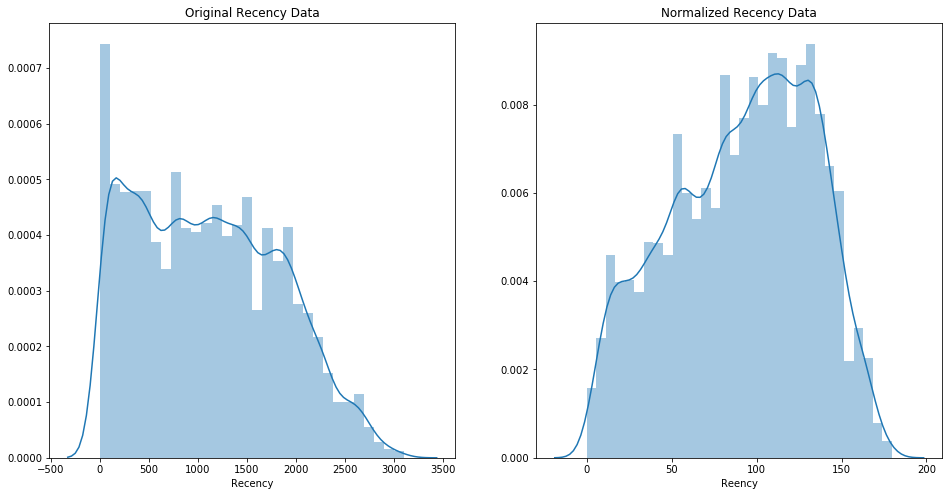

In [256]:
# normalize Recency column with boxcox
normalized_data2 = stats.boxcox(df_processed_for_transformation.Recency)
# plot both together to compare
fig, ax=plt.subplots(1,2, figsize=(16,8))
sns.distplot(df_processed_for_transformation.Recency, ax=ax[0])
ax[0].set_title("Original Recency Data")
sns.distplot(normalized_data2[0], ax=ax[1])
plt.xlabel("Reency")
ax[1].set_title("Normalized Recency Data")

_Figure 4: The distribution of Recency column before and after normalization with box-cox transformation._

In [257]:
# combining normalization data into one dataframe
df_processed_for_transformation = df_processed_for_transformation.copy()
df_processed_for_transformation = df_processed_for_transformation.reset_index()
CustomerID = df_processed_for_transformation['Customer ID'].to_list()
normalized_df = pd.DataFrame({'Customer ID': CustomerID, 'Recency': normalized_data2[0],'Frequency': normalized_data1[0], 'Monetary': normalized_data[0]})
normalized_df = normalized_df.set_index('Customer ID')
normalized_df.head()

,Recency,Frequency,Monetary
Customer ID,,,
7,46.226689,0.375429,2.456313
9,177.689716,0.000000,2.325159
30,176.837531,0.000000,3.108451
34,179.486676,0.000000,3.730472
38,179.283899,0.000000,3.152281


Now we will scale our data to have them centered.

In [258]:
# standardization with StandardScaler
normalized_df = normalized_df.copy()
scaler = StandardScaler()
df_processed_scaled = scaler.fit_transform(normalized_df)
df_processed_scaled

array([[-1.0743186 ,  1.68524716, -1.32790905],
       [ 2.07648307, -0.62719173, -1.48776413],
       [ 2.05605857, -0.62719173, -0.53306203],
       ...,
       [-2.1618049 , -0.62719173,  0.70197685],
       [-2.18224326, -0.62719173, -1.12640713],
       [-2.18224326, -0.62719173,  0.62366501]])

In [259]:
# let's check if standartization was done without mistakes
print(df_processed_scaled.mean(axis=0)) # should be around 0
print(df_processed_scaled.std(axis=0)) # should be around 1

[-2.12680965e-16 -7.53245086e-17 -2.90220901e-16]
[1. 1. 1.]


In [260]:
# transform array into a dataframe
df_processed_scaled = pd.DataFrame(df_processed_scaled, index = normalized_df.index, columns = normalized_df.columns)
display(df_processed_scaled.head())

,Recency,Frequency,Monetary
Customer ID,,,
7,-1.074319,1.685247,-1.327909
9,2.076483,-0.627192,-1.487764
30,2.056059,-0.627192,-0.533062
34,2.119551,-0.627192,0.225077
38,2.114691,-0.627192,-0.479640


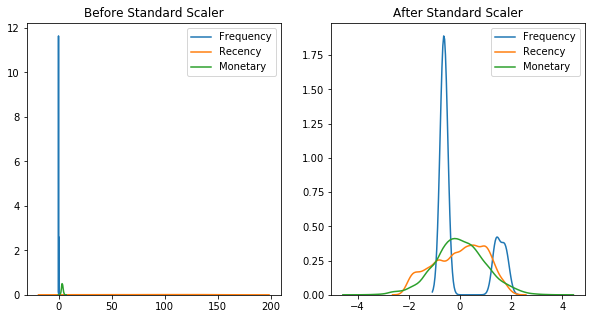

In [261]:
# before and after scaling vizualizations
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.set_title('Before Standard Scaler')
sns.kdeplot(normalized_df['Frequency'], ax=ax1)
sns.kdeplot(normalized_df['Recency'], ax=ax1)
sns.kdeplot(normalized_df['Monetary'], ax=ax1)

ax2.set_title('After Standard Scaler')
sns.kdeplot(df_processed_scaled['Frequency'], ax=ax2)
sns.kdeplot(df_processed_scaled['Recency'], ax=ax2)
sns.kdeplot(df_processed_scaled['Monetary'], ax=ax2)

_Figure 5: The distribution of all columns before and after standartization with Standard Scaler transformation._

# Elbow Method for optimal value of k in KMeans

Now when we have our data standardized we need to determine the optimal number of clusters for this I will use the Elbow method. THe approach of the elbow method is the following first we calculate the Within Cluster Sum of Squared Errors (WCSS) for different values of k, and choose the k for which WSS first starts to diminish. In the plot of WSS-versus k, this is visible as an elbow.

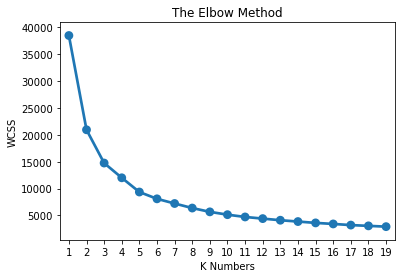

In [262]:
# the Elbow method
df_processed_scaled = df_processed_scaled.copy()
df_processed_scaled_elb = df_processed_scaled
wcss = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(df_processed_scaled_elb)
    wcss[k] = kmeans.inertia_
# plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.title('The Elbow Method')
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

_Figure 6: Determination of the optimal number of clusters for Kmeans using the Elbow method._

The optimal K value is found to be 4 using the elbow method.

In [263]:
# clustering with optimal number of clusters
clus = KMeans(n_clusters=4, init='k-means++', max_iter= 300)
y_means = clus.fit_predict(df_processed_scaled_elb)
# Assign the clusters to data
df_processed_scaled_elb['K_Cluster'] = clus.labels_
df_processed_scaled_elb.head()

,Recency,Frequency,Monetary,K_Cluster
Customer ID,,,,
7,-1.074319,1.685247,-1.327909,0
9,2.076483,-0.627192,-1.487764,1
30,2.056059,-0.627192,-0.533062,1
34,2.119551,-0.627192,0.225077,1
38,2.114691,-0.627192,-0.479640,1


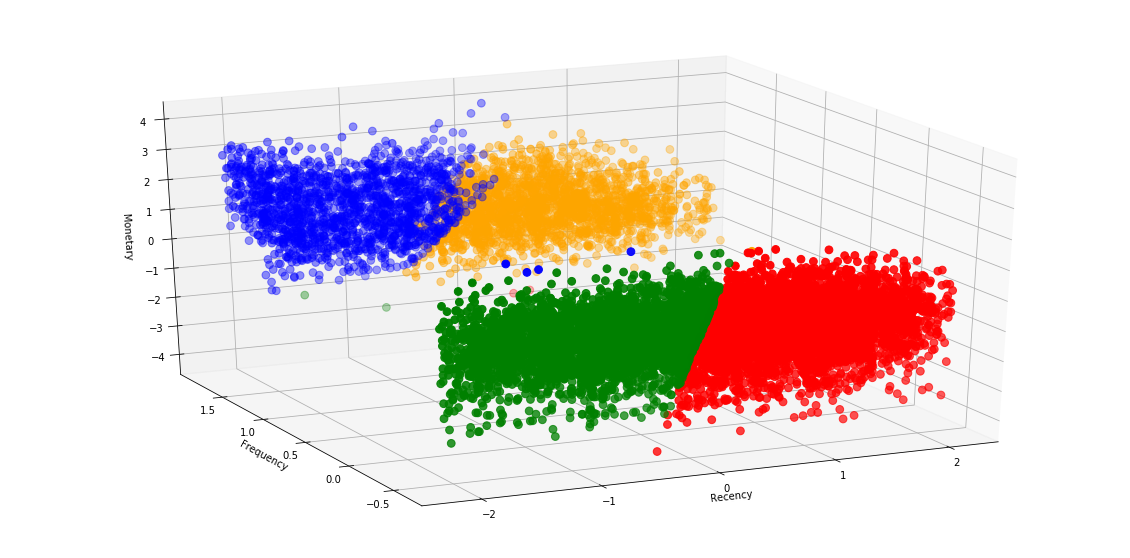

In [264]:
# vizualization
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_processed_scaled_elb['Recency'][df_processed_scaled_elb.K_Cluster == 0], df_processed_scaled_elb["Frequency"][df_processed_scaled_elb.K_Cluster == 0], df_processed_scaled_elb["Monetary"][df_processed_scaled_elb.K_Cluster == 0], c='blue', s=60)
ax.scatter(df_processed_scaled_elb['Recency'][df_processed_scaled_elb.K_Cluster == 1], df_processed_scaled_elb["Frequency"][df_processed_scaled_elb.K_Cluster == 1], df_processed_scaled_elb["Monetary"][df_processed_scaled_elb.K_Cluster == 1], c='red', s=60)
ax.scatter(df_processed_scaled_elb['Recency'][df_processed_scaled_elb.K_Cluster == 2], df_processed_scaled_elb["Frequency"][df_processed_scaled_elb.K_Cluster == 2], df_processed_scaled_elb["Monetary"][df_processed_scaled_elb.K_Cluster == 2], c='green', s=60)
ax.scatter(df_processed_scaled_elb['Recency'][df_processed_scaled_elb.K_Cluster == 3], df_processed_scaled_elb["Frequency"][df_processed_scaled_elb.K_Cluster == 3], df_processed_scaled_elb["Monetary"][df_processed_scaled_elb.K_Cluster == 3], c='orange', s=60)

ax.view_init(25,245)
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
plt.show()

_Figure 7: Vizualization of clusters, where k was determined by the Elbow method ._

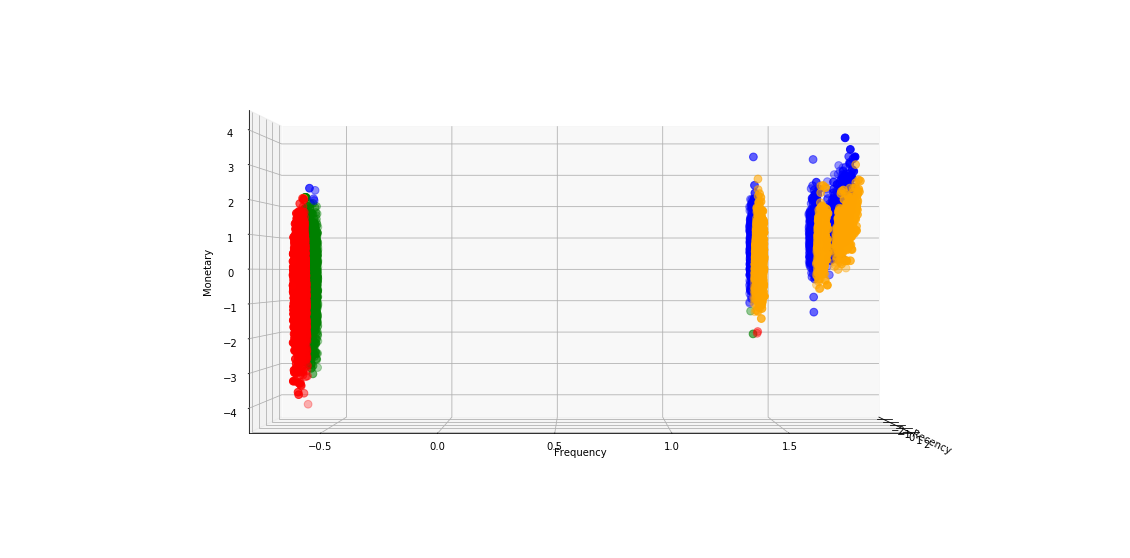

In [265]:
# vizualization at a different angle
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_processed_scaled_elb['Recency'][df_processed_scaled_elb.K_Cluster == 0], df_processed_scaled_elb["Frequency"][df_processed_scaled_elb.K_Cluster == 0], df_processed_scaled_elb["Monetary"][df_processed_scaled_elb.K_Cluster == 0], c='blue', s=60)
ax.scatter(df_processed_scaled_elb['Recency'][df_processed_scaled_elb.K_Cluster == 1], df_processed_scaled_elb["Frequency"][df_processed_scaled_elb.K_Cluster == 1], df_processed_scaled_elb["Monetary"][df_processed_scaled_elb.K_Cluster == 1], c='red', s=60)
ax.scatter(df_processed_scaled_elb['Recency'][df_processed_scaled_elb.K_Cluster == 2], df_processed_scaled_elb["Frequency"][df_processed_scaled_elb.K_Cluster == 2], df_processed_scaled_elb["Monetary"][df_processed_scaled_elb.K_Cluster == 2], c='green', s=60)
ax.scatter(df_processed_scaled_elb['Recency'][df_processed_scaled_elb.K_Cluster == 3], df_processed_scaled_elb["Frequency"][df_processed_scaled_elb.K_Cluster == 3], df_processed_scaled_elb["Monetary"][df_processed_scaled_elb.K_Cluster == 3], c='orange', s=60)

ax.view_init(0,0)
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
plt.show()

_Figure 8: Vizualization of clusters, where k was determined by the Elbow method._

As it is seen from the graph, the blue cluster would represent customers with high frequency and monetary values, these customers would be called 'superstar'. However, red cluster would represent 'dormant' customers, as the frequency and monetary values are quite low. The green and yellow clusters would represent the 'golden' and 'typical' customers, as they have high either frequency ('golden') or monetary values ('typical'). Let's add the catecory to a customer ID.

In [275]:
def apply_rfm_level_elbow(value):
    state = ''
    if value == 0:
        state = 'superstar'
    elif value == 1:
        state = 'dormant'
    elif value == 2:
        state == 'typical'
    else:
        state = 'golden'
    return state

df_processed_scaled_elb['RFM_level'] = df_processed_scaled_elb['K_Cluster'].apply(apply_rfm_level_elbow)
df_processed_scaled_elb.head()

,Recency,Frequency,Monetary,K_Cluster,RFM_level
Customer ID,,,,,
7,-1.074319,1.685247,-1.327909,0,superstar
9,2.076483,-0.627192,-1.487764,1,dormant
30,2.056059,-0.627192,-0.533062,1,dormant
34,2.119551,-0.627192,0.225077,1,dormant
38,2.114691,-0.627192,-0.479640,1,dormant


# Silhouette analysis for optimal value of k in KMeans

The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). The range of the Silhouette value is between +1 and -1. A high value indicates that the point is placed in the correct cluster. If many points have a negative Silhouette value, it may indicate that we have created too many or too few clusters.

[0.474638618081743, 0.3943557544579402, 0.3868650678246593, 0.3654556002090036, 0.3501714201923569, 0.3382895495033205, 0.33455979412527004, 0.3493288915342232, 0.3383462545720151, 0.3352338498418074, 0.32944747296955046, 0.32309468329272095, 0.32231266054060975]


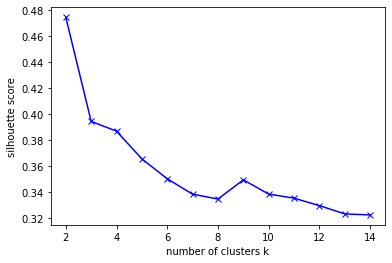

In [266]:
# Silhouette values for different k
df_processed_scaled = df_processed_scaled.copy()
df_processed_scaled_sih = df_processed_scaled[['Recency', 'Frequency', 'Monetary']]
df_processed_scaled_sih.head()
s = []
K = range(2,15)
for k in K:
    kmeanModel = KMeans(n_clusters = k, random_state = 0).fit(df_processed_scaled_sih)
    labels = kmeanModel.fit_predict(df_processed_scaled_sih)
    s.append(silhouette_score(df_processed_scaled_sih, labels))   
print(s)
plt.plot(K,s, 'bx-')
plt.xlabel('number of clusters k')
plt.ylabel('silhouette score')
plt.show()

_Figure 9: Determination of the optimal number of clusters for Kmeans using the Silhouette analysis._

In sihouette analysis we are looking for the higherst score or the maximum at the optimal k. The highest score was observed with 2 clusters. Let's use k=2 for our rfm model.

In [267]:
# clustering with an optimal k 
clus = KMeans(n_clusters=2, init='k-means++', max_iter= 300)
y_means = clus.fit_predict(df_processed_scaled_sih)
# Assign the clusters to data
df_processed_scaled_sih['K_Cluster_sih'] = clus.labels_
df_processed_scaled_sih.head()

,Recency,Frequency,Monetary,K_Cluster_sih
Customer ID,,,,
7,-1.074319,1.685247,-1.327909,1
9,2.076483,-0.627192,-1.487764,0
30,2.056059,-0.627192,-0.533062,0
34,2.119551,-0.627192,0.225077,0
38,2.114691,-0.627192,-0.479640,0


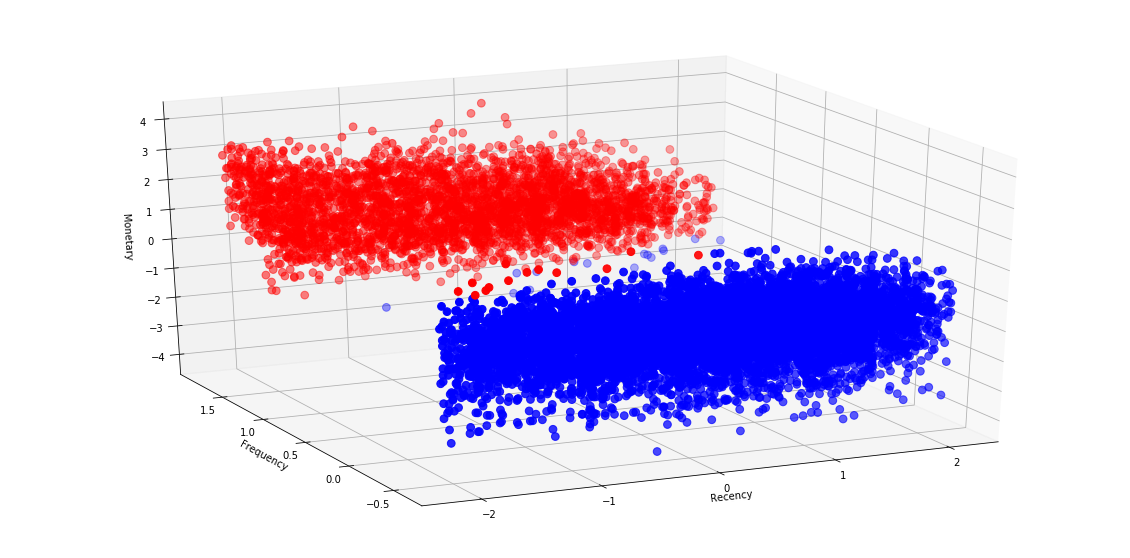

In [268]:
# vizualization
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_processed_scaled_sih['Recency'][df_processed_scaled_sih.K_Cluster_sih == 0], df_processed_scaled_sih["Frequency"][df_processed_scaled_sih.K_Cluster_sih == 0], df_processed_scaled_sih["Monetary"][df_processed_scaled_sih.K_Cluster_sih == 0], c='blue', s=60)
ax.scatter(df_processed_scaled_sih['Recency'][df_processed_scaled_sih.K_Cluster_sih == 1], df_processed_scaled_sih["Frequency"][df_processed_scaled_sih.K_Cluster_sih == 1], df_processed_scaled_sih["Monetary"][df_processed_scaled_sih.K_Cluster_sih == 1], c='red', s=60)

ax.view_init(25,245)
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
plt.show()

_Figure 10: Vizualization of clusters, where k was determined by Silhuette method._

According to this analysis, the blue cluster would have the high Monetary and Frequency values, which symbolizes the superstar customers, while the red cluster would have low Frequency and Monetary values and symbolize dormant customers. Let's add the catecory to a customer ID.

In [276]:
def apply_rfm_level_sih(value):
    state = ''
    if value == 1:
        state = 'superstar'
    elif value == 0:
        state = 'dormant'
    return state
     

df_processed_scaled_sih['RFM_level'] = df_processed_scaled_sih['K_Cluster_sih'].apply(apply_rfm_level_sih)
df_processed_scaled_sih.head()

,Recency,Frequency,Monetary,K_Cluster_sih,RFM_level
Customer ID,,,,,
7,-1.074319,1.685247,-1.327909,1,superstar
9,2.076483,-0.627192,-1.487764,0,dormant
30,2.056059,-0.627192,-0.533062,0,dormant
34,2.119551,-0.627192,0.225077,0,dormant
38,2.114691,-0.627192,-0.479640,0,dormant


# Gap statistic for optimal value of k in KMeans 

Both methods, Elbow method and Silhouette analysis, showed different number of clusters for KMeans. So I decided to try a different approach and used Gap statistic to find the k (https://anaconda.org/milesgranger/gap-statistic/notebook). 

In [284]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [285]:
df_processed_scaled = df_processed_scaled.copy()
df_processed_scaled_gap=df_processed_scaled[['Recency', 'Frequency', 'Monetary']]
display(df_processed_scaled_gap.head())
k, gapdf = optimalK(df_processed_scaled_gap, nrefs=3, maxClusters=10)
print('Optimal number of clusters (k) is: ', k)

,Recency,Frequency,Monetary
Customer ID,,,
7,-1.074319,1.685247,-1.327909
9,2.076483,-0.627192,-1.487764
30,2.056059,-0.627192,-0.533062
34,2.119551,-0.627192,0.225077
38,2.114691,-0.627192,-0.479640


Optimal number of clusters (k) is:  5


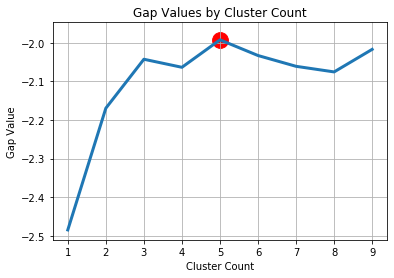

In [286]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

_Figure 11: Determination of the optimal number of clusters for Kmeans using the Gap statistic analysis._

In [287]:
# clustering with an optimal k 
clus = KMeans(n_clusters=5, init='k-means++', max_iter= 300)
y_means = clus.fit_predict(df_processed_scaled_gap)
# Assign the clusters to data
df_processed_scaled_gap['K_Cluster_gap'] = clus.labels_
df_processed_scaled_gap.head()

,Recency,Frequency,Monetary,K_Cluster_gap
Customer ID,,,,
7,-1.074319,1.685247,-1.327909,1
9,2.076483,-0.627192,-1.487764,0
30,2.056059,-0.627192,-0.533062,0
34,2.119551,-0.627192,0.225077,4
38,2.114691,-0.627192,-0.479640,0


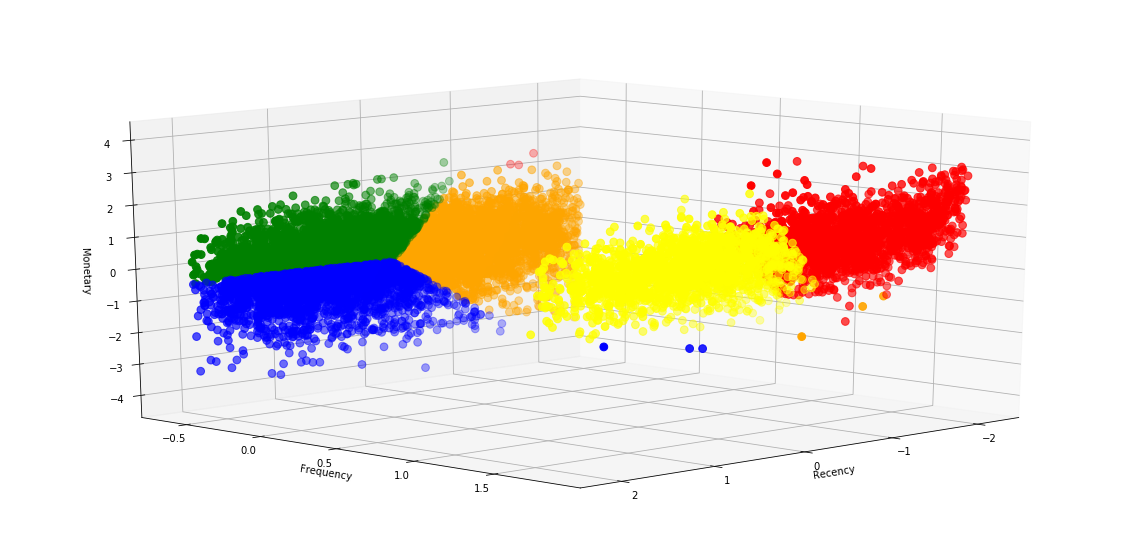

In [288]:
# vizualization
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_processed_scaled_gap['Recency'][df_processed_scaled_gap.K_Cluster_gap == 0], df_processed_scaled_gap["Frequency"][df_processed_scaled_gap.K_Cluster_gap == 0], df_processed_scaled_gap["Monetary"][df_processed_scaled_gap.K_Cluster_gap == 0], c='blue', s=60)
ax.scatter(df_processed_scaled_gap['Recency'][df_processed_scaled_gap.K_Cluster_gap == 1], df_processed_scaled_gap["Frequency"][df_processed_scaled_gap.K_Cluster_gap == 1], df_processed_scaled_gap["Monetary"][df_processed_scaled_gap.K_Cluster_gap == 1], c='red', s=60)
ax.scatter(df_processed_scaled_gap['Recency'][df_processed_scaled_gap.K_Cluster_gap == 2], df_processed_scaled_gap["Frequency"][df_processed_scaled_gap.K_Cluster_gap == 2], df_processed_scaled_gap["Monetary"][df_processed_scaled_gap.K_Cluster_gap == 2], c='yellow', s=60)
ax.scatter(df_processed_scaled_gap['Recency'][df_processed_scaled_gap.K_Cluster_gap == 3], df_processed_scaled_gap["Frequency"][df_processed_scaled_gap.K_Cluster_gap == 3], df_processed_scaled_gap["Monetary"][df_processed_scaled_gap.K_Cluster_gap == 3], c='orange', s=60)
ax.scatter(df_processed_scaled_gap['Recency'][df_processed_scaled_gap.K_Cluster_gap == 4], df_processed_scaled_gap["Frequency"][df_processed_scaled_gap.K_Cluster_gap == 4], df_processed_scaled_gap["Monetary"][df_processed_scaled_gap.K_Cluster_gap == 4], c='green', s=60)


ax.view_init(15,45)
plt.xlabel("Recency")
plt.ylabel("Frequency")
ax.set_zlabel('Monetary')
plt.show()

_Figure 12: Vizualization of clusters, where k was determined by Gap static method._

According to this analysis, the green cluster would symbolize 'superstar' customers, while the red cluster would represent 'dormant' customers. THe yellow cluster symbolizes 'golden' customers, while orange cluster symbolizes exceptional occasions customers, as they have low Frequency and low recency values. The blue cluster would symbolize typical customers.  LLet's add the catecory to a customer ID.

In [290]:
def apply_rfm_level_gap(value):
    state = ''
    if value == 0:
        state = 'dormant'
    elif value == 1:
        state = 'superstar'
    elif value == 2:
        state == 'golden'
    elif value == 3:
        state == 'exceptional occasions customer'
    else:
        state = 'typical'
    return state

df_processed_scaled_gap['RFM_level'] = df_processed_scaled_gap['K_Cluster_gap'].apply(apply_rfm_level_gap)
df_processed_scaled_gap.head()

,Recency,Frequency,Monetary,K_Cluster_gap,RFM_level
Customer ID,,,,,
7,-1.074319,1.685247,-1.327909,1,superstar
9,2.076483,-0.627192,-1.487764,0,dormant
30,2.056059,-0.627192,-0.533062,0,dormant
34,2.119551,-0.627192,0.225077,4,exceptional occasions customer
38,2.114691,-0.627192,-0.479640,0,dormant


# Conclusion

Different methods for the determination of the number of clusters resulted in the diffrent k (Figure 13). There is also another method to get the number of clusters, but it is implemented in R package (NbClust). It is hard to discuss, which method showed the most probable value. Many articles say that the Elbow method is a very naive approach to determine the number of clusters, as it is not clear from the curve what k we should choose.However, the interpretation of superstar and dormant customers with the Silhouette method would be quite hard as it resulted in two big separated far from each other clusters. In this particular case, I would trust the Gap statistic analysis as it cleaarly separated the dormant customers.

Text(0, 0.5, 'the number of cluster (k)')

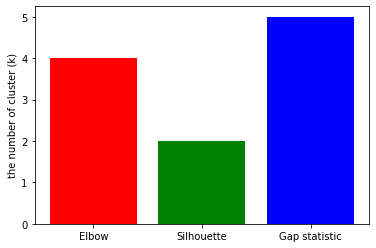

In [291]:
l1 = ['Elbow', 'Silhouette', 'Gap statistic']
l2 = [4, 2, 5]
colors= ['r','g', 'b']
plt.bar(l1,l2, color=colors)
plt.ylabel('the number of cluster (k)')

_Figure 13: Summary of methods used to determine the optimal number of clusters._

The segmentation of customers to different levels were performed according to the table given below (Data Mining Techniques in CRM: Inside Customer Segmentation
By Konstantinos K. Tsiptsis, Antonios).

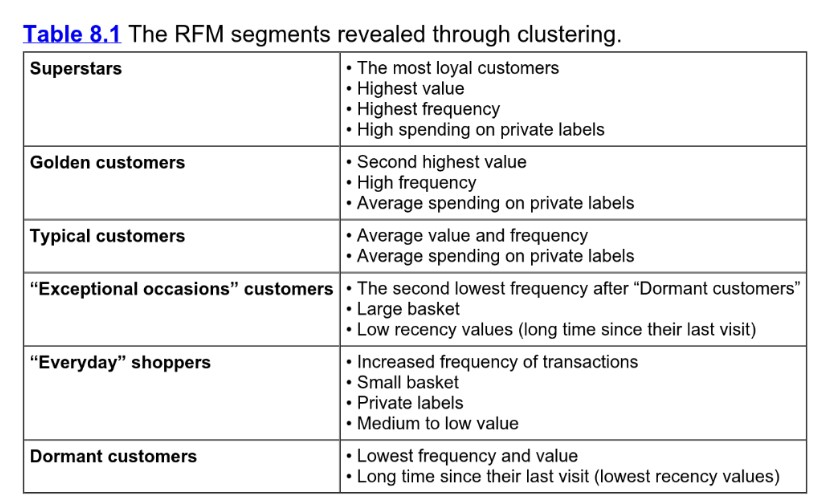

In [40]:
from IPython.display import Image
Image("Screenshot_7.jpg")